# Import Libraries

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.models import ResNet50_Weights
from tqdm.auto import tqdm
import os

## For Google Colab Users

This cell is for mounting your Google Drive to the Colab Notebook. If you are not using Google Colab, you can skip this cell

In [147]:
# from google.colab import drive
# drive.mount('/content/drive')

In [148]:
# Check for GPU
# device = "cuda" if torch.cuda.is_available() else "cpu"

# Check for GPU in mac
device = "mps" if torch.backends.mps.is_available() else "cpu"

device

'mps'

# Data 

## Transforming Data

In [149]:
data_transforms = {
    'Training' : transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

## Loading Data

In [150]:
# directory: where training and testing data are
base_path = os.getcwd()
data_dir = os.path.join(base_path, 'data/TUMOR/')    

TRAINING = 'Training'
TESTING = 'Testing'
directories = [TRAINING, TESTING]

# datasets.ImageFolder: (https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)
# torch.utils.data.DataLoader: (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

# image_datasets are dictionary of (type of dataset, dataloader)
# type of dataset are training and testing
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in directories}

# DataLoader helps us for better performance and experience in data loading
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in directories}

dataset_sizes = {x: len(image_datasets[x]) for x in directories}
class_names = image_datasets['Training'].classes

dataset_sizes, class_names

({'Training': 2770, 'Testing': 394},
 ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

## Samples of data

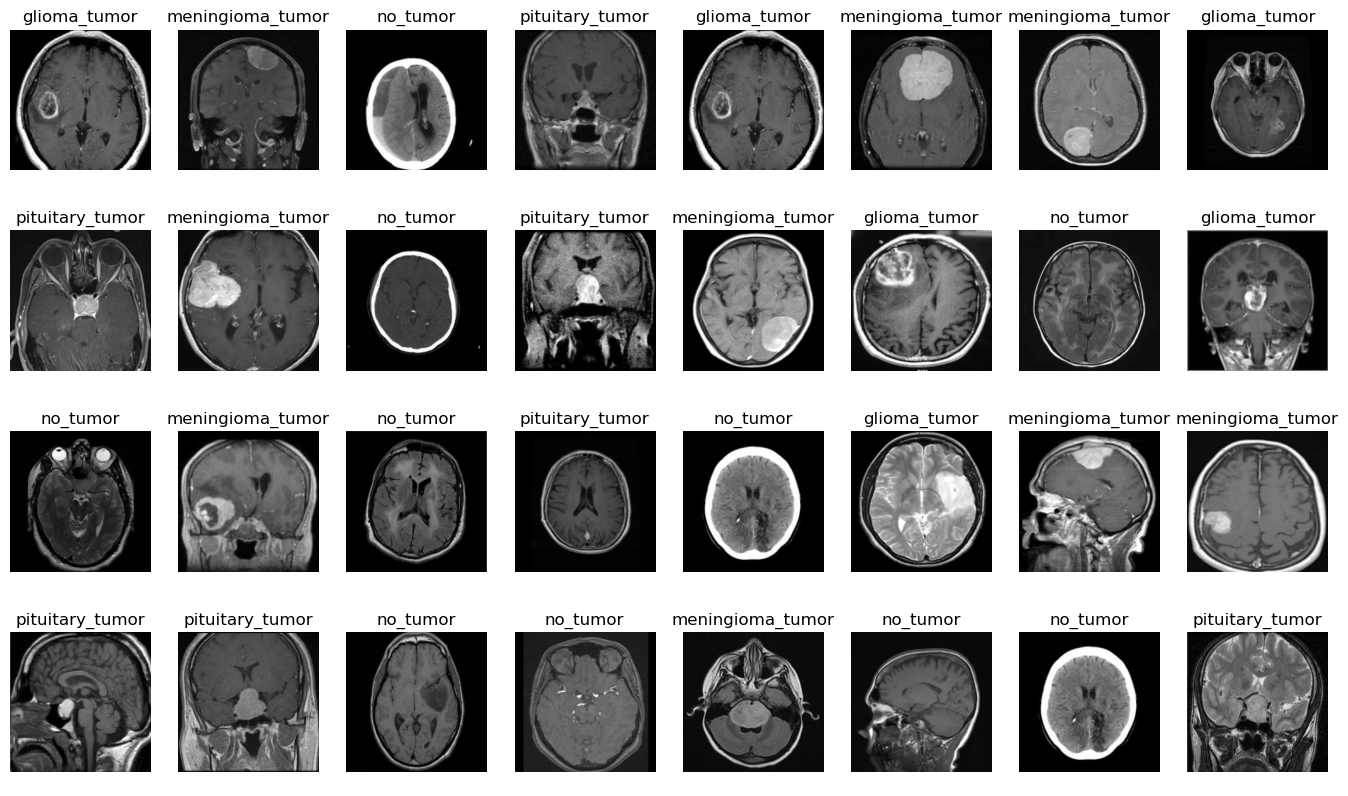

In [151]:
samples, labels = next(iter(dataloaders['Testing']))
plt.figure(figsize=(17, 10))
plt.axis('off')
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(samples[i].permute(1, 2, 0))
    plt.title(class_names[labels[i]])
    plt.axis('off')

# Model

## Loading Model

In [152]:
# Loading are pretrained model in this task our model is resnet50 (https://www.youtube.com/watch?v=mGMpHyiN5lk)

# Loading pretrained model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False
    
for param in model.layer4.parameters():
    param.requires_grad = True

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Preparing Model

In [153]:
# You have to change the (fc) layer of the model to compatible with your data
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 4),
    nn.Softmax(dim=1),
)

model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

## Loss function

In [154]:
criterion = nn.CrossEntropyLoss()

## Optimizer

In [155]:
# # you have to change it for better performance
# optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.05)
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.001},
    {'params': model.fc.parameters(), 'lr': 0.01, 'weight_decay': 0.05},
])

## Others

In [156]:
# you can have other thongs like learning rate scheduler and ...
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7) ->> Delete this shit

## Train

In [157]:
losses = []
EPOCH = 40

# for training part you have to set model to train mode
model.train()

# loop on epochs
for e in tqdm(range(EPOCH)):

  # loop on batches
  for inputs, labels in dataloaders[TRAINING]:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # set the grad to zero
    optimizer.zero_grad()
    
    # forward part
    # hint: using of pytorch max method (https://pytorch.org/docs/stable/generated/torch.max.html)
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)  

    #  compute loss
    loss = criterion(outputs, labels)
    
    # backward part
    loss.backward()

    # update parameters
    optimizer.step()

  # you have to append loss for each epoch
  losses.append(loss.item())

  0%|          | 0/40 [00:00<?, ?it/s]

## Plot loss function

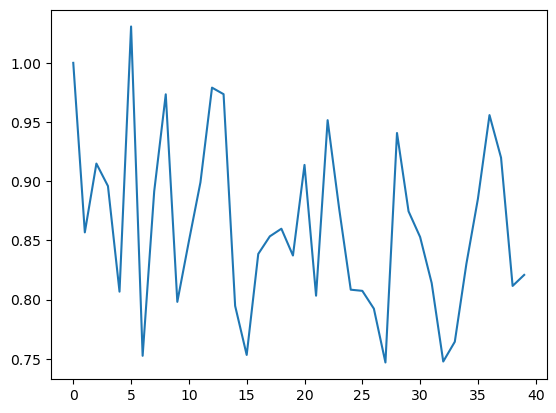

In [159]:
# you have to calculate losses array in the Train part
plt.plot(list(range(len(losses))), losses)
plt.show()

## Evaluate model

In [160]:
def calc_accuracy(data, model):
  corrects = 0

  # for testing part you have to set model to eval mode
  model.eval()
  for inputs, labels in tqdm(dataloaders[data]):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
  return corrects.float() / dataset_sizes[data]

In [161]:
# accuracy of training data
calc_accuracy(TRAINING, model)

  0%|          | 0/87 [00:00<?, ?it/s]

tensor(0.9534, device='mps:0')

In [162]:
    # accuracy of testing data
calc_accuracy(TESTING, model)

  0%|          | 0/13 [00:00<?, ?it/s]

tensor(0.7792, device='mps:0')

# Saving Model

In [163]:
PATH = os.path.join(base_path, 'model.ci')
torch.save(model, PATH)

# Loading and eval Model

In [164]:
PATH = os.path.join(base_path, 'model.ci')

model_for_eval = torch.load(PATH)
model_for_eval.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [165]:
model_for_eval

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [166]:
# accuracy of training data by loaded model
calc_accuracy(TRAINING, model_for_eval)

  0%|          | 0/87 [00:00<?, ?it/s]

tensor(0.9509, device='mps:0')

In [167]:
# accuracy of testing data by loaded model
calc_accuracy(TESTING, model_for_eval)

  0%|          | 0/13 [00:00<?, ?it/s]

tensor(0.7792, device='mps:0')